In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May  1 15:06:25 2023

@author: maria popovic
"""

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from numpy import pi, matrix, arcsin, sqrt, arccos
import matplotlib.pyplot as plt
from numpy import array, exp, append
import random
import math
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, PhaseEstimation, CPhaseGate, RYGate, Reset
from qiskit.circuit import Parameter
from qiskit.opflow import X,Y,Z,I
from qiskit.extensions import UnitaryGate


/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_13118/3942663230.py:18: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X,Y,Z,I


In [2]:
### Load data time series ###

import pandas as pd

file = pd.read_excel('Backtest_Validation_Hist.xlsx',sheet_name='Daily returns')

data_daily = file['YIELDCURVE.EUR-MSWAP.ZERO.EUR(T365)'].tolist()

file2 = pd.read_excel('Backtest_Validation_Hist.xlsx',sheet_name='TS')

data = file2['YIELDCURVE.EUR-MSWAP.ZERO.EUR(T365)'].tolist()

data_initial_rate = []
data_yearly = []
index = 0
while (index + 251) < len(data_daily):
    data_initial_rate.append(data[index])
    data_yearly.append(sum(data_daily[index:index + 251]))
    index = index + 5
    

In [3]:
# Set Hamiltonian

a = 0.6
b = 0.15
r = 0.75

# Define operators
H = a*(Z^I) + b*(I^Z) + r*(I^I)
U = H.exp_i() # Evolution operator for H with t = 1
U = U.to_matrix()
U_Dagger = matrix(U).getH()

U_Gate = UnitaryGate(U, label = 'U').control(1)
U_Dagger_Gate = UnitaryGate(U_Dagger, label = r'$U^{\dag}$').control(1)

# Quantum phase estimation (QPE)

In [4]:
def energy_state(result, n):
    
    num_result = int(result,2)
    
    if num_result == 0:
        
        energy_positive = 0
    
    else: 
        energy_positive = 2*pi*(2**(n) - num_result)/(2**(n))
    
    energy_negative = (-2*pi*num_result)/(2**(n))

    
    return energy_positive, energy_negative


def quantum_phase_estimation(energy_register, state_register, unitary):
    
    phase_circuit = QuantumCircuit(energy_register, state_register, name='QPE')
    
    iqft = QFT(num_qubits = len(energy_register), do_swaps = True, inverse = True) 
    
    iqft = iqft.to_gate()
    
    for qubit in energy_register:
        phase_circuit.h(qubit)
    
    for index in range(0, len(energy_register)):
    
        counts = 1
        while counts <= 2**(index):
            phase_circuit.append(unitary, [energy_register[index], *state_register])
            counts = counts + 1

    phase_circuit.append(iqft,energy_register)
    
    phase_circuit = phase_circuit.to_gate()
    

    return phase_circuit


def inverse_quantum_phase_estimation(energy_register, state_register, unitary):
    
    phase_circuit = QuantumCircuit(energy_register, state_register, name=r'$QPE^{\dagger}$')
    
    qft = QFT(num_qubits = len(energy_register), do_swaps = True, inverse = False) 
    
    qft = qft.to_gate()
    
    phase_circuit.append(qft, energy_register)

    for index in range(0, len(energy_register)):
    
        counts = 1
        while counts <= 2**(len(energy_register) - 1 - index):
            phase_circuit.append(unitary, [energy_register[len(energy_register) - 1 - index], *state_register])
            counts = counts + 1
        
    #for qubit in energy_register:
        #phase_circuit.reset(qubit)
        
    phase_circuit = phase_circuit.to_gate()

    return phase_circuit

# Iterative phase estimation (IPE)

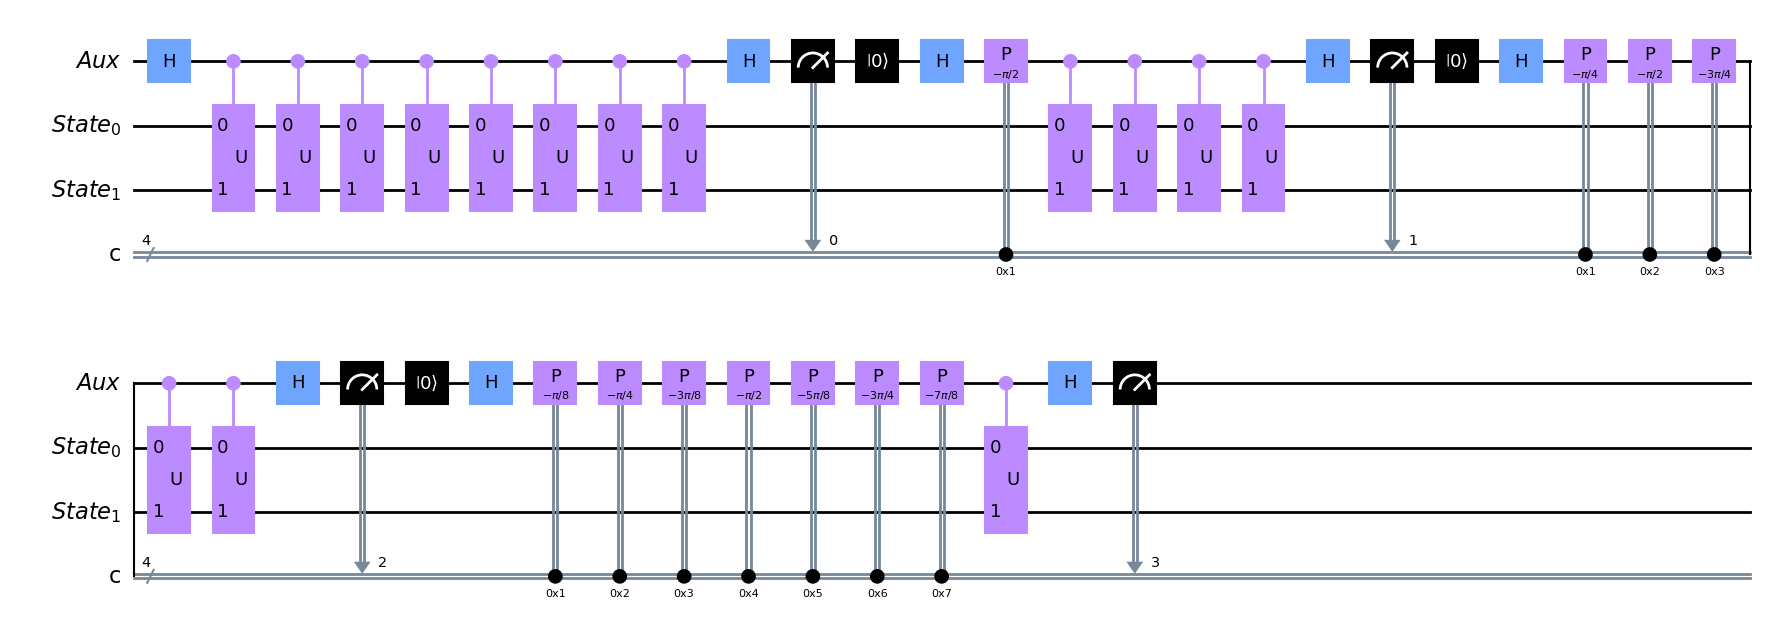

{'0.0': 4, '0.8125': 52, '0.9375': 3, '0.1875': 1, '0.4375': 2, '0.75': 917, '0.25': 3, '0.625': 2, '0.6875': 27, '0.5625': 5, '0.5': 2, '0.875': 6}


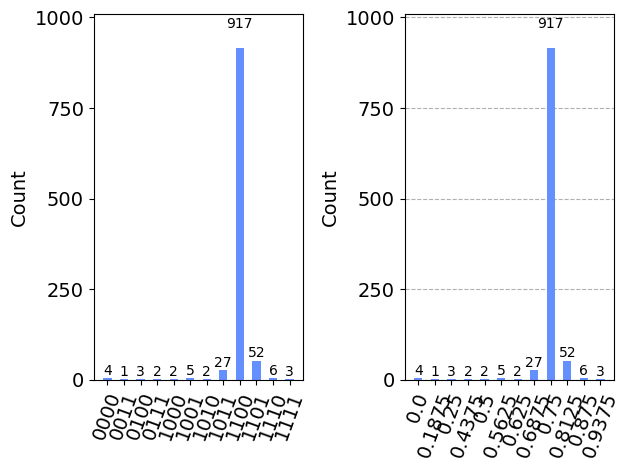

In [17]:
state_bits = 2
precision = 4
aux = QuantumRegister(1, name = 'Aux')
state_register = QuantumRegister(state_bits,name='State')
classical_register = ClassicalRegister(precision, name = 'c')
circuit2 = QuantumCircuit(aux, state_register, classical_register)
#circuit2.x(state_register[0])
#circuit2.x(state_register[1])

def iterative_phase_estimation(phase_circuit, m, state_register, classical_register, unitary):
    
    def x_measurement(qc, qubit, cbit):
        """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
        qc.h(qubit)
        qc.measure(qubit, cbit)
    
    phase_circuit.h(aux)
    
    #
    for _ in range(2**(m - 1)):
        phase_circuit.append(unitary, [aux, *state_register])
    
    x_measurement(phase_circuit, aux, classical_register[0])
    
    phase_circuit.reset(aux)
    phase_circuit.h(aux)
    
    phase_circuit.p(-pi/2,0).c_if(classical_register,1)
    #
    for _ in range(2**(m - 2)):
        phase_circuit.append(unitary, [aux, *state_register])
        
    x_measurement(phase_circuit, aux, classical_register[1])
    
    phase_circuit.reset(aux)
    phase_circuit.h(aux)
    
    phase_circuit.p(-pi/4,0).c_if(classical_register,1)
    phase_circuit.p(-pi/2,0).c_if(classical_register,2)
    phase_circuit.p(-3*pi/4,0).c_if(classical_register,3)
    #
    for _ in range(2**(m - 3)):
        phase_circuit.append(unitary, [aux, *state_register])
    
    x_measurement(phase_circuit, aux, classical_register[2])
    
    phase_circuit.reset(aux)
    phase_circuit.h(aux)
        
    phase_circuit.p(-pi/8,0).c_if(classical_register,1)
    phase_circuit.p(-pi/4,0).c_if(classical_register,2)
    phase_circuit.p(-3*pi/8,0).c_if(classical_register,3)
    phase_circuit.p(-pi/2,0).c_if(classical_register,4)
    phase_circuit.p(-5*pi/8,0).c_if(classical_register,5)
    phase_circuit.p(-3*pi/4,0).c_if(classical_register,6)
    phase_circuit.p(-7*pi/8,0).c_if(classical_register,7)
    
    #
    for _ in range(2**(m - 4)):
        phase_circuit.append(unitary, [aux, *state_register])
    
    phase_circuit.h(aux)
        
    phase_circuit.measure(aux, classical_register[3])
    
    return phase_circuit
    
iterative_phase_estimation(circuit2, precision, state_register, classical_register, U_Gate)

display(circuit2.draw('mpl'))

simulator = Aer.get_backend('qasm_simulator')

count0 = execute(circuit2, simulator).result().get_counts()
key_new = [str(int(key,2)/2**precision) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))
print(count1)

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
fig.tight_layout()


In [5]:
# BOLTZMANN COIN FOR 4-QUBIT REGISTER ENERGIES

def boltzmann_coin(energyCurrent, energyNext, coin):
    
    beta = 4
    
    energy_bits = len(energyCurrent)
    
    BCoin = QuantumCircuit(energyNext, energyCurrent, coin, name='Boltzmann Coin')
    
    # Accept new step circuit: if E_k < E_i, 100% accept
    
    BCoin.x(coin)
    
    # Reject new step circuit: if E_k > E_i, sin^2(theta/2) accept, cos^2(theta/2) reject
    
    controls = append(energyCurrent, energyNext)
    
    theta1 = 2*arccos(exp(-(beta*pi*1)/(2**energy_bits)))
    theta2 = 2*arccos(exp(-(beta*pi*2)/(2**energy_bits)))
    theta3 = 2*arccos(exp(-(beta*pi*3)/(2**energy_bits)))
    theta4 = 2*arccos(exp(-(beta*pi*4)/(2**energy_bits)))
    theta5 = 2*arccos(exp(-(beta*pi*5)/(2**energy_bits)))
    theta6 = 2*arccos(exp(-(beta*pi*6)/(2**energy_bits)))
    theta7 = 2*arccos(exp(-(beta*pi*7)/(2**energy_bits)))
    theta8 = 2*arccos(exp(-(beta*pi*8)/(2**energy_bits)))
    theta9 = 2*arccos(exp(-(beta*pi*9)/(2**energy_bits)))
    theta10 = 2*arccos(exp(-(beta*pi*10)/(2**energy_bits)))
    theta11 = 2*arccos(exp(-(beta*pi*11)/(2**energy_bits)))
    theta12 = 2*arccos(exp(-(beta*pi*12)/(2**energy_bits)))
    theta13 = 2*arccos(exp(-(beta*pi*13)/(2**energy_bits)))
    theta14 = 2*arccos(exp(-(beta*pi*14)/(2**energy_bits)))
    theta15 = 2*arccos(exp(-(beta*pi*15)/(2**energy_bits)))
    # For zero energy, different rules
    psi1 = 2*arccos(exp(- beta*pi*(1 - (1/(2**energy_bits)))))
    psi2 = 2*arccos(exp(- beta*pi*(1 - (2/(2**energy_bits)))))
    psi3 = 2*arccos(exp(- beta*pi*(1 - (3/(2**energy_bits)))))
    psi4 = 2*arccos(exp(- beta*pi*(1 - (4/(2**energy_bits)))))
    psi5 = 2*arccos(exp(- beta*pi*(1 - (5/(2**energy_bits)))))
    psi6 = 2*arccos(exp(- beta*pi*(1 - (6/(2**energy_bits)))))
    psi7 = 2*arccos(exp(- beta*pi*(1 - (7/(2**energy_bits)))))
    psi8 = 2*arccos(exp(- beta*pi*(1 - (8/(2**energy_bits)))))
    psi9 = 2*arccos(exp(- beta*pi*(1 - (9/(2**energy_bits)))))
    psi10 = 2*arccos(exp(- beta*pi*(1 - (10/(2**energy_bits)))))
    psi11 = 2*arccos(exp(- beta*pi*(1 - (11/(2**energy_bits)))))
    psi12 = 2*arccos(exp(- beta*pi*(1 - (12/(2**energy_bits)))))
    psi13 = 2*arccos(exp(- beta*pi*(1 - (13/(2**energy_bits)))))
    psi14 = 2*arccos(exp(- beta*pi*(1 - (14/(2**energy_bits)))))
    psi15 = 2*arccos(exp(- beta*pi*(1 - (15/(2**energy_bits)))))
    
    
    #0
    BCoin.x(energyCurrent)
    
    BCoin.x([energyNext[1],energyNext[2],energyNext[3]])   
    BCoin.append(RYGate(psi1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(psi2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(psi3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #

    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(psi4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
 
    BCoin.append(RYGate(psi5).control(2*energy_bits), [*controls,coin])
    BCoin.x(energyNext[1])
    #BCoin.barrier()
    #
    BCoin.x(energyNext[0])
    BCoin.append(RYGate(psi6).control(2*energy_bits), [*controls,coin])
    BCoin.x(energyNext[0])
    #BCoin.barrier()
    #
    BCoin.append(RYGate(psi7).control(2*energy_bits), [*controls,coin])
    BCoin.x(energyNext[3])
    #BCoin.barrier()
    #

    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(psi8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(psi9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]]) 
    BCoin.append(RYGate(psi10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
 
    BCoin.append(RYGate(psi11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])    
    BCoin.append(RYGate(psi12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
   
    BCoin.append(RYGate(psi13).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])    
    BCoin.append(RYGate(psi14).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
        
    BCoin.append(RYGate(psi15).control(2*energy_bits), [*controls,coin])

    BCoin.x(energyCurrent)
    #BCoin.barrier() 
    
    #1
    BCoin.x(energyCurrent[3])
    
    
    BCoin.x([energyCurrent[1],energyCurrent[2]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    
    BCoin.x([energyCurrent[1],energyCurrent[2]])    
    #BCoin.barrier()
    #2
    BCoin.x([energyCurrent[0],energyCurrent[2]])
    
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1],energyNext[2],energyNext[3]])
    
    BCoin.x([energyCurrent[0],energyCurrent[2]])
    #BCoin.barrier()
    #3
    BCoin.x([energyCurrent[2]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[2],energyNext[3]])
    
    BCoin.x([energyCurrent[2]])
    #BCoin.barrier()
    #4
    BCoin.x([energyCurrent[1],energyCurrent[0]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2],energyNext[3]])
    
    BCoin.x([energyCurrent[1],energyCurrent[0]])
    #BCoin.barrier()
    #5
    BCoin.x([energyCurrent[1]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[1],energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1],energyNext[0],energyNext[3]])
      
    BCoin.x([energyCurrent[1]])
    #BCoin.barrier()
    #6
    BCoin.x([energyCurrent[0]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1],energyNext[3]])
    
    BCoin.x([energyCurrent[0]])
    #BCoin.barrier()
    #7

    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[3]])
    
    BCoin.x(energyCurrent[3])
    #BCoin.barrier()
    
    #8
    BCoin.x([energyCurrent[0],energyCurrent[1],energyCurrent[2]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    
    
    
    BCoin.x([energyCurrent[0],energyCurrent[1],energyCurrent[2]])
    #BCoin.barrier()
    #9
    BCoin.x([energyCurrent[1],energyCurrent[2]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2],energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[3]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    
    BCoin.x([energyCurrent[1],energyCurrent[2]])
    #BCoin.barrier()
    #10
    BCoin.x([energyCurrent[0],energyCurrent[2]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2],energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[3]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1],energyNext[2]])

    
    BCoin.x([energyCurrent[0],energyCurrent[2]])
    #BCoin.barrier()
    #11
    BCoin.x([energyCurrent[2]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2],energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[3]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[2]])
    
    
    
    BCoin.x([energyCurrent[2]])
    #BCoin.barrier()
    #12
    BCoin.x([energyCurrent[0],energyCurrent[1]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])

    
    BCoin.x([energyCurrent[0],energyCurrent[1]])
    #BCoin.barrier()
    #13
    BCoin.x([energyCurrent[1]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta13).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #   
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[1]])
    #BCoin.barrier()
    
    
    BCoin.x([energyCurrent[1]])
    #BCoin.barrier()
    #14
    BCoin.x([energyCurrent[0]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta14).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta13).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
 
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])

    
    BCoin.x([energyCurrent[0]])
    #BCoin.barrier()
    #15
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta15).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta14).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta13).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    
    
    BCoin = BCoin.to_gate()
    
    
    return BCoin

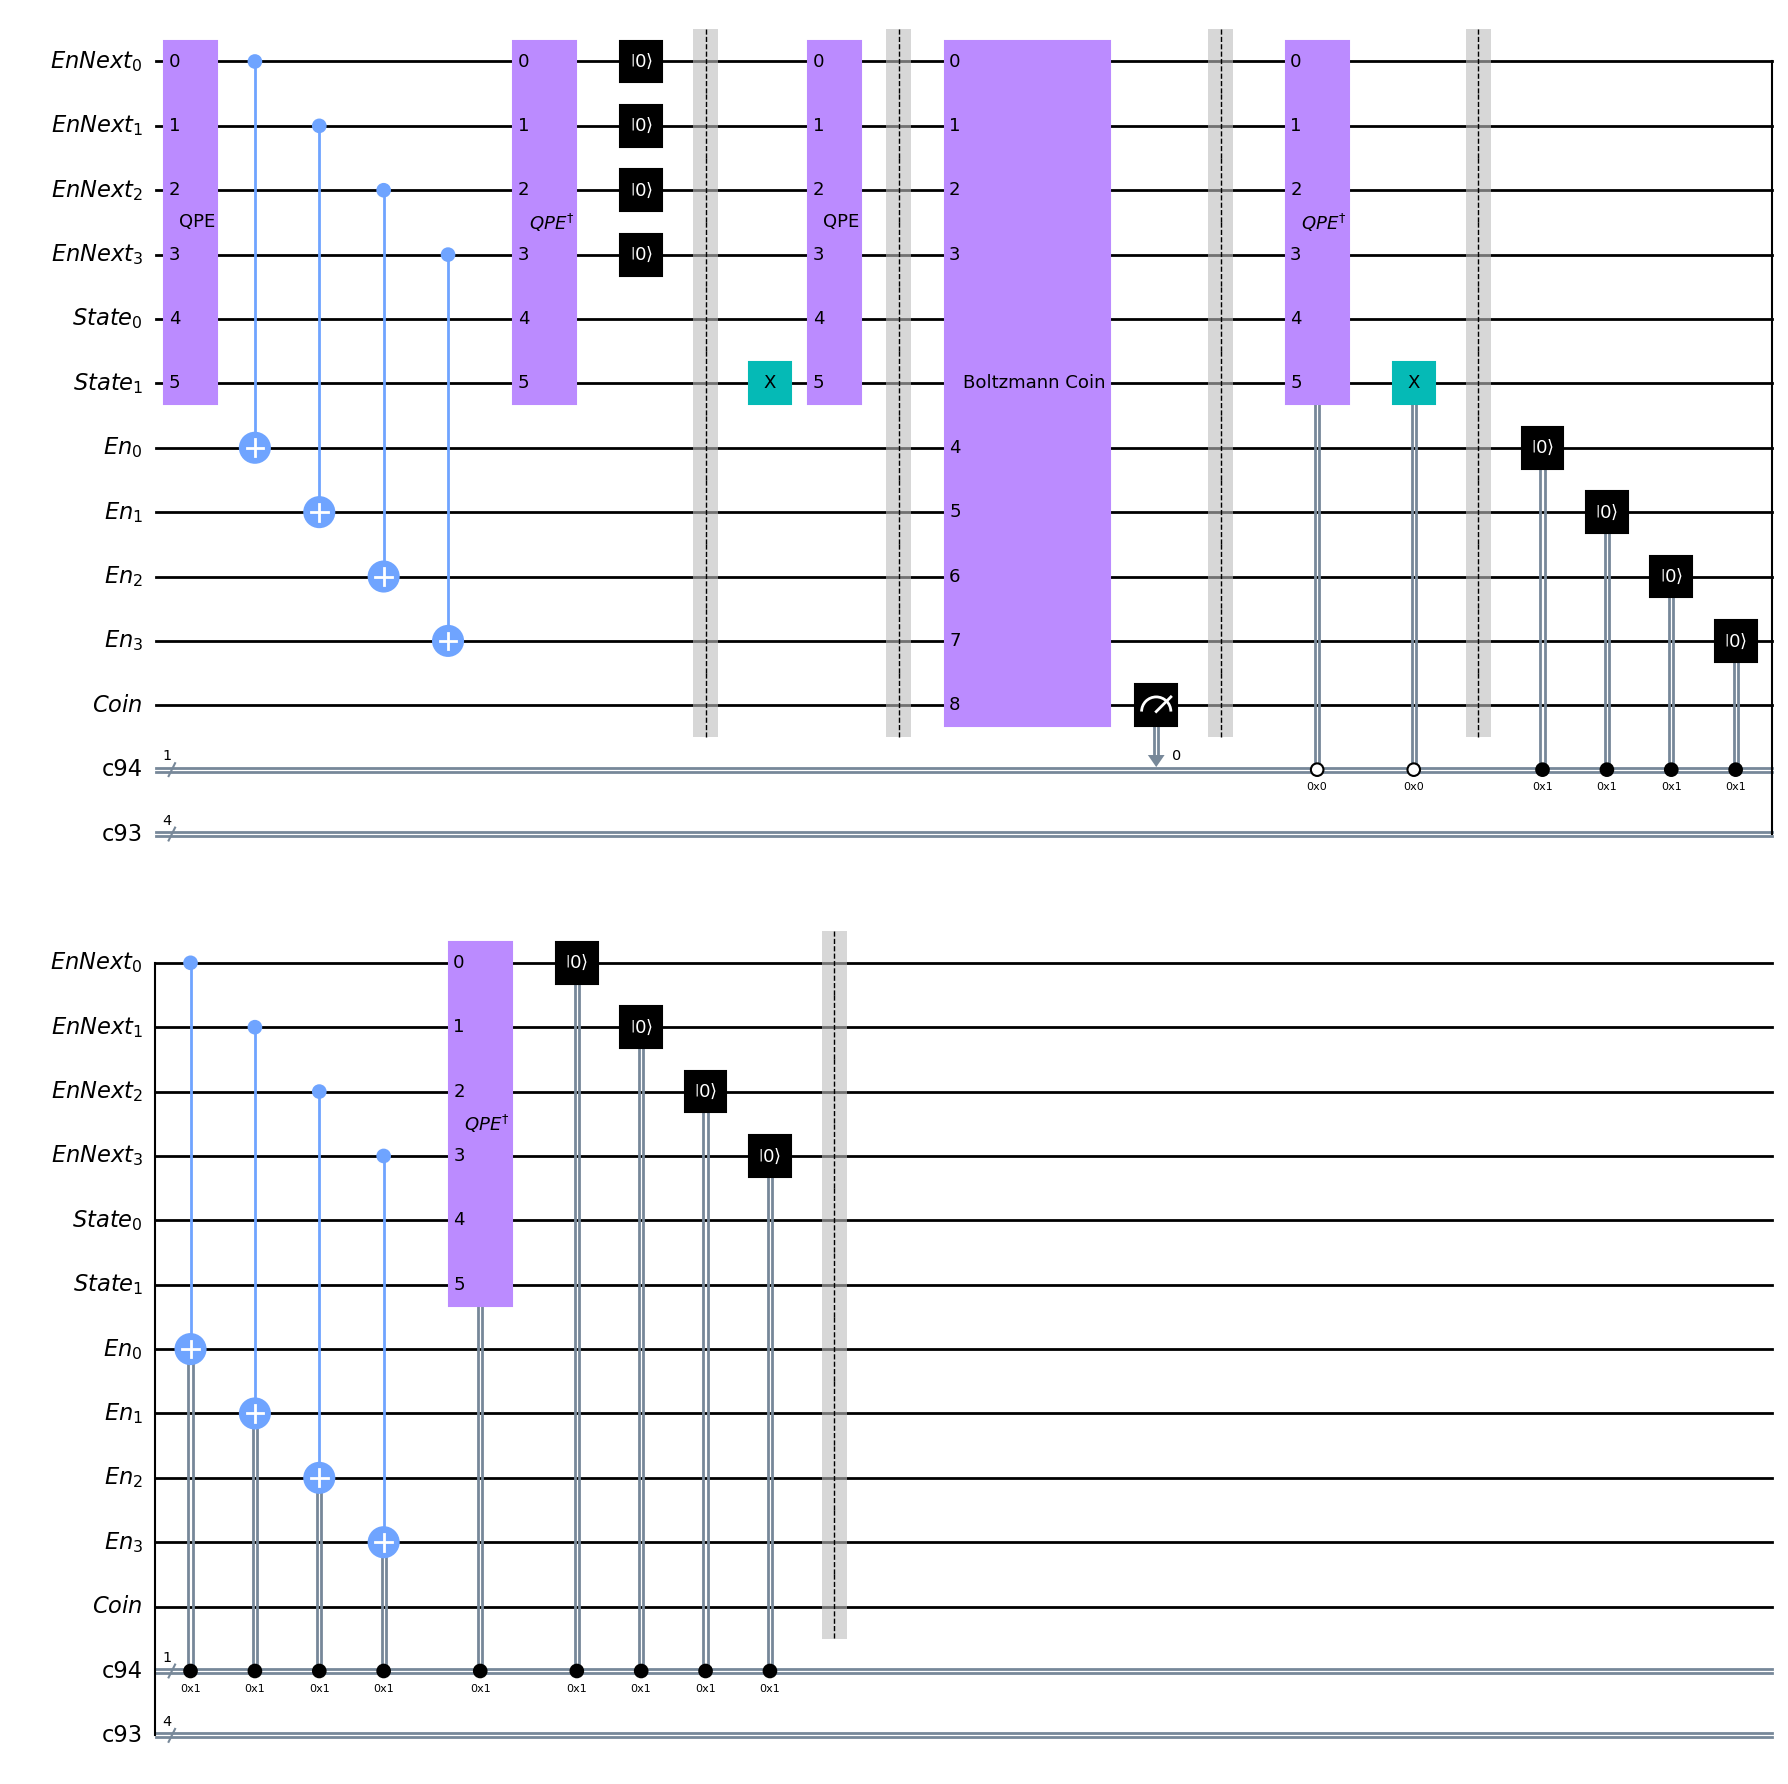

{'1111 1': 1}
{'1100 1': 1}
{'0000 1': 1}
{'0000 0': 1}
{'0000 0': 1}
{'1111 1': 1}
{'0000 0': 1}
{'0000 0': 1}
{'0000 0': 1}
{'0000 0': 1}


In [12]:
state_bits = 2
energy_bits = 4

# Simulation

simulator = Aer.get_backend('qasm_simulator')
   
# Quantum registers

next_energy_register = QuantumRegister(energy_bits,name='EnNext')

state_register = QuantumRegister(state_bits,name='State')

current_energy_register = QuantumRegister(energy_bits,name='En')

coin_register = QuantumRegister(1,name='Coin')

# Classical register

nextEn_classical_register = ClassicalRegister(energy_bits)

currentEn_classical_register = ClassicalRegister(energy_bits)

coin_classical_register = ClassicalRegister(1)

# Create circuit

circuit = QuantumCircuit(next_energy_register, state_register, current_energy_register, coin_register)
circuit.add_register(coin_classical_register)
circuit.add_register(currentEn_classical_register)

# Initialize circuit

#circuit.x(state_register[0])
#circuit.x(state_register[1])

# PHASE ESTIMATION

circuit.append(quantum_phase_estimation(next_energy_register, state_register, U_Gate),[*next_energy_register, *state_register])


# COPY OF ENERGY VALUE

for index in range(0, energy_bits):
    circuit.cx(next_energy_register[index], current_energy_register[index])

# INVERSE PHASE ESTIMATION
circuit.append(inverse_quantum_phase_estimation(next_energy_register, state_register, U_Dagger_Gate),[*next_energy_register, *state_register])

for qubit in next_energy_register:
        circuit.reset(qubit)
        
circuit.barrier()

# Iterative circuit

energy_list = ['1100']

tot_iterations = 10

for it in range(1, tot_iterations + 1):

    for _ in range(it):
        
        # RANDOM WALK STEP: SINGLE-SPIN FLIP
        u = random.randrange(2)

        if u == 1:
            circuit.x(state_register[0])
        else:
            circuit.x(state_register[1])

        # PHASE ESTIMATION

        circuit.append(quantum_phase_estimation(next_energy_register, state_register, U_Gate),[*next_energy_register, *state_register])

        circuit.barrier()

        # BOLTZMANN COIN

        circuit.append(boltzmann_coin(current_energy_register,next_energy_register, coin_register),[*next_energy_register, *current_energy_register, coin_register])
    
        # Measure

        circuit.measure(coin_register, coin_classical_register)
        circuit.barrier()

        # Reject new step

        circuit.append(inverse_quantum_phase_estimation(next_energy_register, state_register, U_Dagger_Gate),[*next_energy_register, *state_register]).c_if(coin_classical_register,0)
        if u == 1:
            circuit.x(state_register[0]).c_if(coin_classical_register,0)
        else:
            circuit.x(state_register[1]).c_if(coin_classical_register,0)
        
        circuit.barrier()

        # Accept new step

        for qubit in current_energy_register:
            circuit.reset(qubit).c_if(coin_classical_register,1)
    
        for index in range(0, energy_bits):
            circuit.cx(next_energy_register[index], current_energy_register[index]).c_if(coin_classical_register,1)
    
        circuit.append(inverse_quantum_phase_estimation(next_energy_register, state_register, U_Dagger_Gate),[*next_energy_register, *state_register]).c_if(coin_classical_register,1)

        for qubit in next_energy_register:
            circuit.reset(qubit).c_if(coin_classical_register,1)
        
        circuit.barrier()

        if it == 1:
            display(circuit.draw('mpl'))

    # Measure

    circuit.measure(current_energy_register, currentEn_classical_register)
    
    count0 = execute(circuit, simulator, shots = 1).result().get_counts()
    print(count0)

    result_bin = ''
    for index in range(energy_bits):
        result_bin = result_bin + list(count0.keys())[0][index]

    energy_list.append(result_bin)
    
    # Initialize circuit again with initial condition:
    
    # Quantum registers

    next_energy_register = QuantumRegister(energy_bits,name='EnNext')

    state_register = QuantumRegister(state_bits,name='State')

    current_energy_register = QuantumRegister(energy_bits,name='En')

    coin_register = QuantumRegister(1,name='Coin')

    # Classical register

    nextEn_classical_register = ClassicalRegister(energy_bits)

    currentEn_classical_register = ClassicalRegister(energy_bits)

    coin_classical_register = ClassicalRegister(1)
    
    circuit = QuantumCircuit(next_energy_register, state_register, current_energy_register, coin_register)
    circuit.add_register(coin_classical_register)
    circuit.add_register(currentEn_classical_register)
    

    #circuit.x(state_register[0])
    #circuit.x(state_register[1])
    
    # PHASE ESTIMATION

    circuit.append(quantum_phase_estimation(next_energy_register, state_register, U_Gate),[*next_energy_register, *state_register])


    # COPY OF ENERGY VALUE

    for index in range(0, energy_bits):
        circuit.cx(next_energy_register[index], current_energy_register[index])

    # INVERSE PHASE ESTIMATION
    circuit.append(inverse_quantum_phase_estimation(next_energy_register, state_register, U_Dagger_Gate),[*next_energy_register, *state_register])

    for qubit in next_energy_register:
        circuit.reset(qubit)
        
    circuit.barrier()


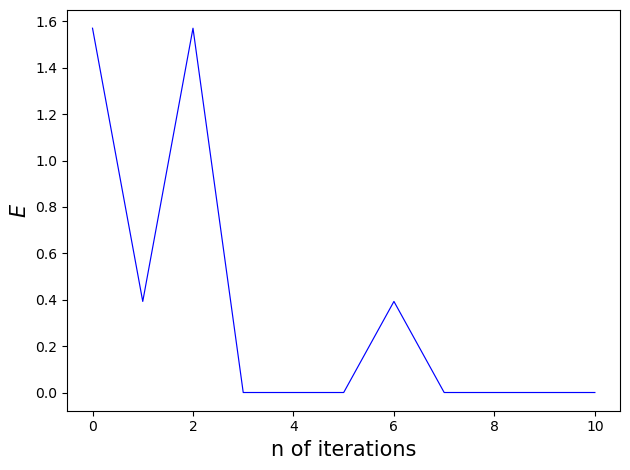

In [14]:
iterations = [x for x in range(0,11)]
energy = []
for el in energy_list:
    en = energy_state(el, energy_bits)[0]
    energy.append(en)
    
f = plt.figure(1)
ax = plt.axes()

ax.plot(iterations, energy, linewidth = 0.85, color = 'blue')


ax.set_xlabel('n of iterations',fontsize=15)
ax.set_ylabel(r'$E$',fontsize=15)

plt.tight_layout()



plt.show()
